## Import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import os
import calendar
from pathlib import Path
parent_dir = Path.cwd().parent.parent.parent

"""
This code is used for Fig1.A. The number of EV chargers by type changes over the period.  
Data: (1) U.S. Boundaries, (2) Summarized data of the number of U.S. EVSE from 2014 to 2024
"""

'\nThis code is used for Fig1.A. The number of EV chargers by type changes over the period.  \nData: (1) U.S. Boundaries, (2) Summarized data of the number of U.S. EVSE from 2014 to 2024\n'

## Data Processing

In [2]:
def load_and_prepare_data(parent_dir):
    """
    Load and prepare US map and EVSE data for analysis.
    """
    # Read US map data
    usa_map_file = parent_dir / 'data' / 'US-map' / 'usa_map.geojson'
    usa_map_gdf = gpd.read_file(usa_map_file)
    
    # Select relevant columns
    usa_map_gdf = usa_map_gdf[['GID_0', 'GID_1', 'GID_2', 'COUNTRY', 'NAME_1', 'NAME_2', 'geometry']]
    
    # Read EVSE summary data
    evse_file = Path.cwd() / 'Fig.1.A_monthly_evse_summary.csv'
    result_df = pd.read_csv(evse_file)
    
    # Calculate total EVSE count
    result_df['EVSE_count'] = result_df['DC_Fast_Count'] + result_df['L1_Count'] + result_df['L2_Count']
    
    print(f"US map data shape: {usa_map_gdf.shape}")
    print(f"EVSE data shape: {result_df.shape}")
    print(f"Total EVSE count: {result_df['EVSE_count'].sum():,}")
    
    return usa_map_gdf, result_df

## Mapping and Visualization

In [3]:
def plot_evse_composition_trend(result_df):
    """
    Plot stacked area chart showing the composition of EV charging stations over time.
    """
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Convert date format
    result_df = result_df.copy()
    result_df['Date'] = pd.to_datetime(result_df['Date'].astype(str))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(13, 8))
    
    # Define custom color scheme
    colors = [
        '#84BA42',  # L2_Count - green
        '#682487',  # L1_Count - purple  
        'teal',     # DC_Fast_Count - teal
    ]
    
    # Create stacked area plot
    ax.stackplot(result_df['Date'], 
                 result_df['L2_Count'],
                 result_df['L1_Count'], 
                 result_df['DC_Fast_Count'], 
                 labels=['AC Level 2 (7-19 kW)', 'AC Level 1 (1-2 kW)', 'DC Fast (50-350 kW)'],
                 colors=colors,
                 alpha=0.85)
    
    # Set labels with bold formatting
    ax.set_xlabel(r'$\bf{Year}$', fontsize=20, labelpad=10)
    ax.set_ylabel(r'$\bf{The\ number\ of\ chargers}$', fontsize=20, labelpad=10)
    
    # Configure x-axis ticks
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # X-axis tick parameters
    ax.tick_params(axis='x', which='major', 
                   labelsize=19, pad=8, rotation=90, 
                   direction='out', length=5, width=1)
    
    # Y-axis tick parameters  
    ax.tick_params(axis='y', which='major',
                   labelsize=19, pad=8,
                   direction='out', length=5, width=1)
    
    # Configure legend
    ax.legend(loc='upper left', frameon=True, 
              fontsize=14, facecolor='white')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    
    print(f"Plot generated: {len(result_df)} data points from {result_df['Date'].min().year} to {result_df['Date'].max().year}")
    
    return fig

In [4]:
def plot_evse_composition_pie(result_df, year=None, save_path=None):
    """
    Plot pie chart showing composition of EV charging stations for a specific year.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Select data based on year parameter
    if year is None:
        # Default: first row (2014)
        pie_data = result_df.iloc[0][['DC_Fast_Count', 'L1_Count', 'L2_Count']]
        year_label = "2014"
    elif year == 'latest':
        # Latest data (2024)
        pie_data = result_df.iloc[-1][['DC_Fast_Count', 'L1_Count', 'L2_Count']]
        year_label = "2024"
    else:
        # Find data for specific year
        result_df['Year'] = pd.to_datetime(result_df['Date']).dt.year
        year_data = result_df[result_df['Year'] == year]
        if len(year_data) == 0:
            raise ValueError(f"No data found for year {year}")
        pie_data = year_data.iloc[0][['DC_Fast_Count', 'L1_Count', 'L2_Count']]
        year_label = str(year)
    
    # Define colors and labels
    colors = ['teal', '#682487', '#84BA42']
    labels = ['DC Fast', 'AC Level 1', 'AC Level 2']
    
    # Create pie chart
    fig, ax = plt.subplots(figsize=(5, 4))
    
    # Plot pie chart
    wedges, texts, autotexts = ax.pie(
        pie_data,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=(0.05, 0, 0),  # Highlight DC Fast segment
        shadow=False,
        textprops={'fontsize': 18}
    )
    
    # Set title
    ax.set_title(r'$\bf{' + year_label + '}$' + '\n' + 'Composition of EV Charging Stations',
                fontsize=18, pad=20)
    
    # Style percentage text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, format='svg', dpi=100, bbox_inches='tight', transparent=True)
        print(f"Pie chart saved to: {save_path}")
    
    print(f"Pie chart generated for {year_label}:")
    print(f"  DC Fast: {pie_data['DC_Fast_Count']:,} ({pie_data['DC_Fast_Count']/pie_data.sum()*100:.1f}%)")
    print(f"  AC Level 1: {pie_data['L1_Count']:,} ({pie_data['L1_Count']/pie_data.sum()*100:.1f}%)")
    print(f"  AC Level 2: {pie_data['L2_Count']:,} ({pie_data['L2_Count']/pie_data.sum()*100:.1f}%)")
    
    return fig

## Test run

US map data shape: (3148, 7)
EVSE data shape: (124, 5)
Total EVSE count: 10,199,107
Plot generated: 124 data points from 2014 to 2024


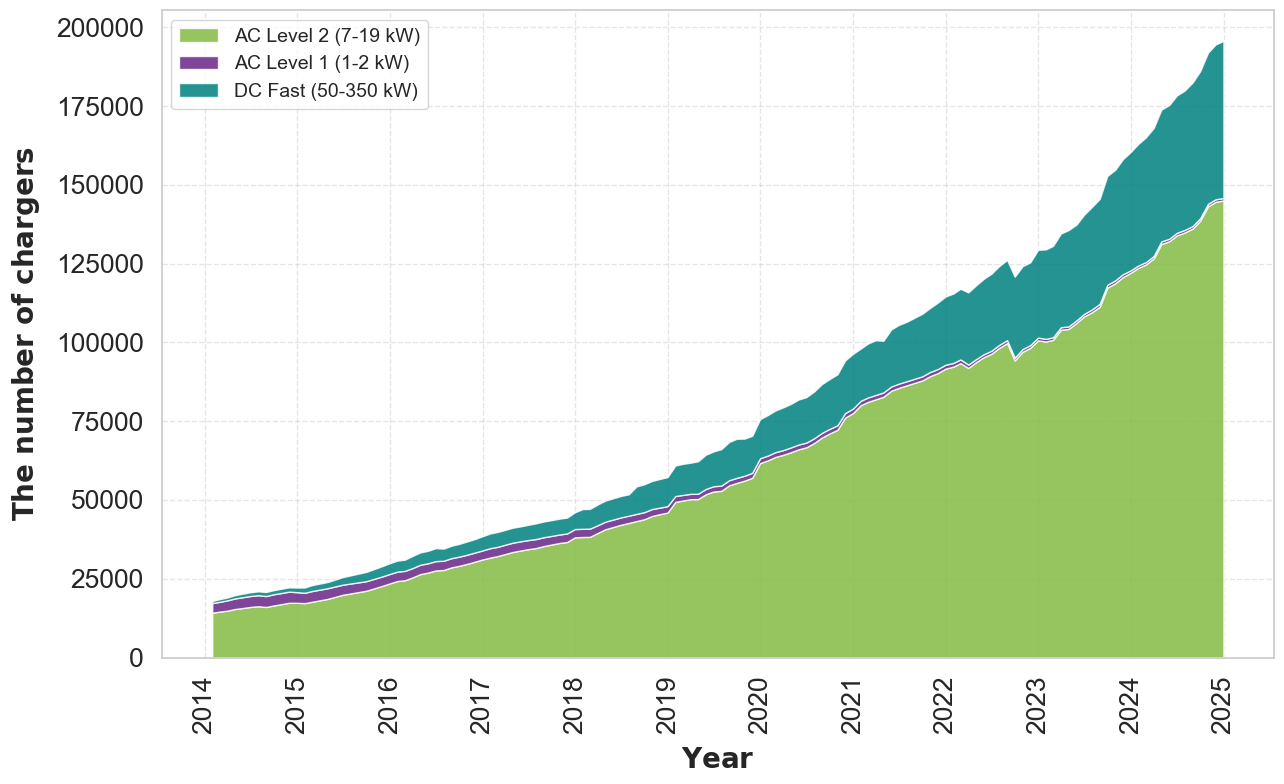

Pie chart generated for 2014:
  DC Fast: 686 (3.8%)
  AC Level 1: 3,024 (16.8%)
  AC Level 2: 14,241 (79.3%)


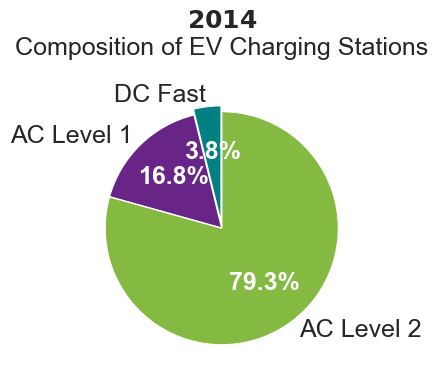

Pie chart generated for 2024:
  DC Fast: 49,867 (25.5%)
  AC Level 1: 788 (0.4%)
  AC Level 2: 145,038 (74.1%)


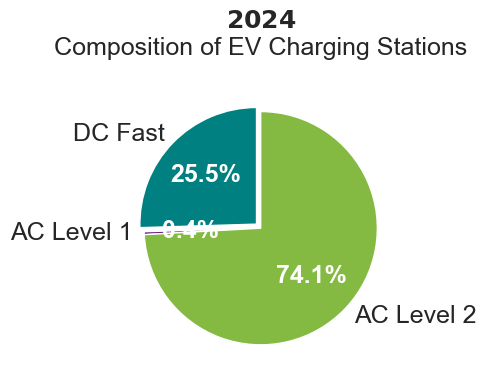

In [5]:
# Usage example:
if __name__ == "__main__":
    usa_map_gdf, result_df = load_and_prepare_data(parent_dir)
    
    # Generate composition plot
    fig = plot_evse_composition_trend(result_df)
    plt.show()

    # Generate 2014 pie chart
    fig_2014 = plot_evse_composition_pie(
        result_df, 
        year=None,  # Uses first row (2014)
        #save_path='ev_charging_piechart2014_1.svg'
    )
    plt.show()
    
    # Generate 2024 pie chart  
    fig_2024 = plot_evse_composition_pie(
        result_df,
        year='latest',  # Uses last row (2024)
        #save_path='ev_charging_piechart2024_1.svg'
    )

    plt.show()